# GMM HMM Word recognizer (single speaker)

In [1]:
# example from here: https://github.com/slegroux/ASR_GMMHMM

In [4]:
import os
import sys
import librosa
import numpy as np
import json
from hmmlearn import hmm
import hmmlearn
import warnings
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

## Data

In [5]:
dictionary = ['apple', 'banana', 'kiwi', 'lime', 'orange', 'peach', 'pineapple']

In [6]:
audio_dir_path = 'data/audio/'

## Read audio and compute mfcc

In [7]:
file = 'data/audio/apple/apple01.wav'

def compute_mfcc(file):
    y, sr = librosa.load(file)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    return(mfcc, y)

mfcc, y = compute_mfcc(file)
print(mfcc.shape)

(13, 15)


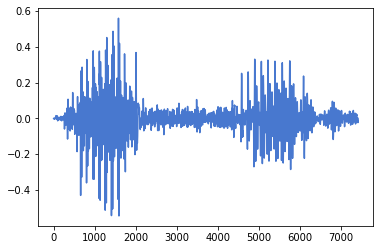

In [8]:
plt.plot(y)

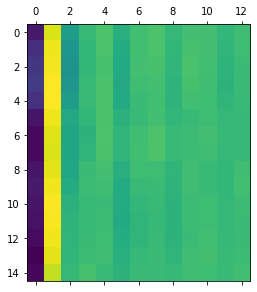

In [9]:
plt.matshow(mfcc.transpose())

## Prepare input 

In [18]:
max = 0
data = {}
for dirpath, dirname, files in os.walk(audio_dir_path):
    for f in files:
        if f.endswith('.wav'):
            content = {
                'label': None,
                'file_path': None,
                'mfcc': None
            }
            file_path = os.path.join(dirpath,f)
            label = dirpath.split('/')[2]
            content['label'] = label
            content['file_path'] = file_path
            content['mfcc'] = compute_mfcc(file_path)[0]
            if content['mfcc'].shape[1] > max:
                max = content['mfcc'].shape[1]
            data[f] = content
d = {}
d['content'] = data
d['max'] = max
content = d['content']
maxi = d['max']

apple
38


(13, 18)

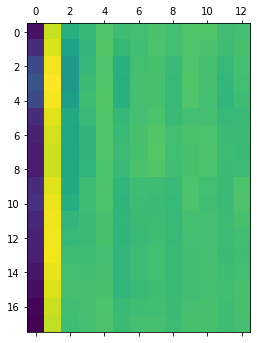

In [19]:
print(d['content']['apple07.wav']['label'])
mfcc_apple07 = d['content']['apple07.wav']['mfcc']
mfcc_kiwi07 = d['content']['kiwi07.wav']['mfcc']
plt.matshow(mfcc_apple07.transpose())
print(d['max'])
mfcc_apple07.shape

## Train / Test

In [20]:
print(mfcc_apple07.transpose().shape)
toto = np.vstack((mfcc_apple07.transpose(), mfcc_apple07.transpose()))
print(toto.shape)

(18, 13)
(36, 13)


In [21]:
X = []
y = []

count = 0
for k in content:
    mfcc = content[k]['mfcc'].transpose()
    n_frames = mfcc.shape[0]

    label = content[k]['label']
    
    if count == 0:
        X = mfcc
        y = [label] * n_frames
        count += 1
    else:
        y = np.hstack((y, [label] * n_frames))
        X = np.vstack((X, mfcc))

print(X.shape)
print(y.shape)

(2497, 13)
(2497,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape)

(1672, 13) (825, 13)


## GMM HMM training

In [23]:
print(dictionary)

['apple', 'banana', 'kiwi', 'lime', 'orange', 'peach', 'pineapple']


In [24]:
y_train

array(['banana', 'pineapple', 'apple', ..., 'lime', 'orange', 'kiwi'],
      dtype='<U9')

In [25]:
models = {}
for fruit in dictionary:
    fruit_data = X_train[y_train==fruit]
    print(fruit_data.shape)
    model = hmm.GaussianHMM(n_components=4, covariance_type='diag', n_iter=1000)
    models[fruit] = model.fit(fruit_data)


(174, 13)
(215, 13)
(183, 13)
(203, 13)
(337, 13)
(298, 13)
(262, 13)


## Model visualization

Each MFCC feature (dim 13) is modeled with 4 different Gaussian components (mean dim 4 x 13 + covariance dim 4 x 13 x 13)

In [26]:
gmm_data = {}
feature_idx = 0

k = 'apple'
def get_mean_var_model(k):
    print(models[k].means_.shape, models[k].covars_.shape)
    mean = models[k].means_[:, feature_idx]
    var = []
    for i in range(models[k].n_components):
        var.append(models[k].covars_[i][feature_idx][feature_idx])
    return(mean, var)

print(k, get_mean_var_model(k))


(4, 13) (4, 13, 13)
apple (array([-466.2221908 , -573.46674041, -634.08056009, -563.45580646]), [429.43565963711126, 871.2960861785939, 704.1429641259259, 1108.4741590143922])


In [27]:
def gauss_func(x, m, var):
    x = np.array(x)
    sigma = np.sqrt(var)
    y = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-0.5 * ((x - m) / sigma)**2)
    return(y)
    
print(gauss_func([0.4,1], 0., 1.))

[0.36827014 0.24197072]


In [30]:
for m, v in zip(mean, var):
    print(m, v)

-466.22219079507005 429.43565963711126
-573.4667404128647 871.2960861785939
-634.0805600884485 704.1429641259259
-563.4558064594514 1108.4741590143922


(4, 13) (4, 13, 13)


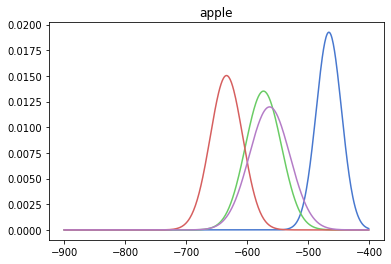

In [31]:
x = range(-900, -400)
k = 'apple'
mean, var = get_mean_var_model(k)
for m, v in zip(mean, var):
    plt.title(k)
    plt.plot(x, gauss_func(x, m, v))

(4, 13) (4, 13, 13)


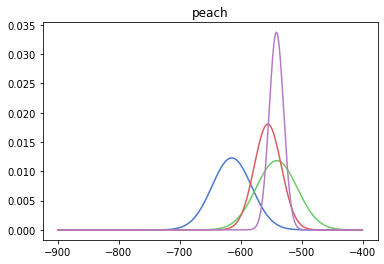

In [34]:
x = range(-900, -400)
k = 'peach'
mean, var = get_mean_var_model(k)
for m, v in zip(mean, var):
    plt.title(k)
    plt.plot(x, gauss_func(x, m, v))

(4, 13) (4, 13, 13)


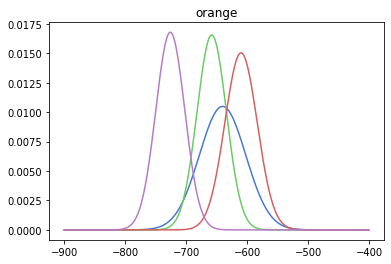

In [35]:
x = range(-900, -400)
k = 'orange'
mean, var = get_mean_var_model(k)
for m, v in zip(mean, var):
    plt.title(k)
    plt.plot(x, gauss_func(x, m, v))

## Inference

In [37]:
apple_test = mfcc_apple07.transpose()
kiwi_test = mfcc_kiwi07.transpose()

def predict_word(mfcc_frames):
    score = -2**64
    for k, v in models.items():
        score_new = models[k].score(mfcc_frames)
#         print(k, score)
        if score_new > score:
            score = score_new
            res = (k, score)

    return(res)

print(predict_word(apple_test))
print(predict_word(kiwi_test))

('apple', -881.1686409880137)
('kiwi', -1020.2978079611373)


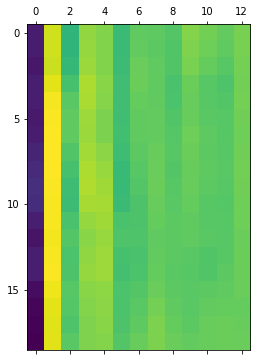

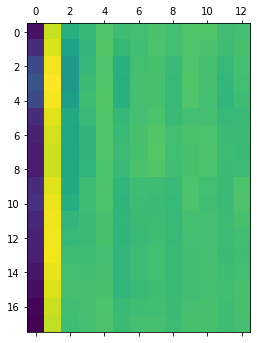

In [38]:
plt.matshow(kiwi_test)
plt.matshow(apple_test)

## References:
- https://medium.com/@kangeugine/hidden-markov-model-7681c22f5b9
- https://kastnerkyle.github.io/posts/single-speaker-word-recognition-with-hidden-markov-models/

In [39]:
hmmlearn.__version__

'0.2.3'